<a href="https://colab.research.google.com/github/SamihaHussein2/EfficientNet-PreTrained-PyTorch/blob/main/EfficientNet_PreTrained_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# m --> my comment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm

In [ ]:
#parameters
batch_size = 100
im_size = 150

In [ ]:
train_set = '/content/drive/MyDrive/programs/Scriba/GlyphDataset/Dataset/Manual/Raw/'
test_set = '/content/drive/MyDrive/programs/Scriba/GlyphDataset/Dataset/Manual/Preprocessed/'
print(test_set)

/content/drive/MyDrive/programs/Scriba/GlyphDataset/Dataset/Manual/Preprocessed/


In [ ]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()
im_size = 150

train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = train_set , transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

mean,std = normalization_parameter(train_loader)

  0%|          | 0/43 [00:00<?, ?it/s]

In [ ]:
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#inverse normalization for image plot

inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [ ]:
import cv2 
import os 
import glob 
import numpy as np
import matplotlib.pyplot as plt 
from skimage.filters import threshold_otsu

image_directory = train_set
images_path = os.path.join(image_directory, '*g')
files = glob.glob(images_path)
ostu_images = []
for image in files:
    img = cv2.imread(image)
    b,g,r = cv2.split(img)
    rgb_img = cv2.merge([r,g,b])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #remove noise
    kernel = np.ones((2,2), np.uint8)
    closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(closing,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
    # Threshold
    ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    ostu_images.append(thresh)
    # plt.imshow(thresh, 'gray')
    # plt.show()

In [ ]:
def data_loader(train_data,test_data = None , valid_size = None , batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders

In [ ]:
#data loader
# train_data = torchvision.datasets.ImageFolder(root = train_set, transform = train_transforms)
test_data = torchvision.datasets.ImageFolder(root = test_set, transform = test_transforms)
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
#label of classes
classes = train_data.classes
print(classes)
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
print(classes)

['20', '21', '22', '23', '3', '39', '41', '5', '7', '9']
['20', '21', '22', '23', '3', '39', '41', '5', '7', '9']


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


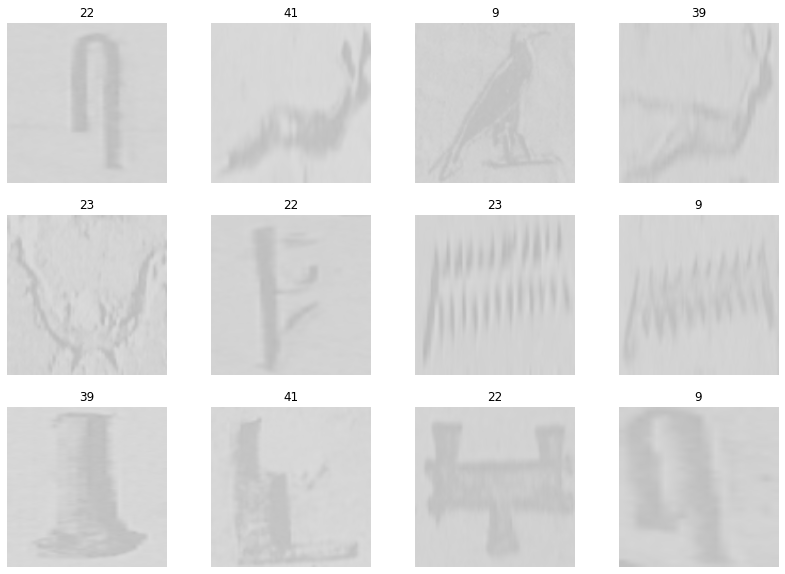

In [ ]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

In [ ]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet =  EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,11)    #modify 6 --> 10  (in pytorch it has to be numofclasses+1 (stackoverflow answer)) (num of classes)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
classifier = Classifier().to(device)

cuda
Loaded pretrained weights for efficientnet-b0


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
import numpy as np
import torch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
def train(model,dataloaders,criterion,num_epochs=10,lr=0.00001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)   # if loss improved
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()  #This will in general have lower memory footprint, and can modestly improve performance instead of giving zero value.
                output = model(data)
                # print(data)
                # print(output.shape)   # el mafrod yetla3 [batch_size,num_of_classes]   --> tale3ly [100,6]   6 el mafrod tkon 10
                # print(target)
                # print(target-1)
                # print("target :",target.data)
                # print("minimum:", min(target))
                # print("maximum:", max(target))
                loss = criterion(output, target)  # hn-check hena
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [ ]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)   # change torch.cuda.FloatTensor --> torch.FloatTensor
        target = target.type(torch.cuda.LongTensor)   # change torch.cuda.LongTensor --> torch,LongTensor   (CPU instead of GPU)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [ ]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [ ]:
def train_model(model,dataloaders,criterion,num_epochs,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

Epoch: 0
train Epoch: 0  [0/4210 (0%)]	Loss: 2.456268 	Acc: 0.070000
False
val Epoch: 0  [0/4215 (0%)]	Loss: 2.731962 	Acc: 0.130000
Validation loss decreased (inf --> 2.513810).  Saving model ...
False
val Accuracy:  0.12777777777777777
Epoch: 1
train Epoch: 1  [0/4210 (0%)]	Loss: 1.510275 	Acc: 0.400000
False
val Epoch: 1  [0/4215 (0%)]	Loss: 3.312612 	Acc: 0.150000
EarlyStopping counter: 1 out of 45
False
val Accuracy:  0.16111111111111112
Epoch: 2
train Epoch: 2  [0/4210 (0%)]	Loss: 0.973369 	Acc: 0.630000
False
val Epoch: 2  [0/4215 (0%)]	Loss: 3.250712 	Acc: 0.210000
EarlyStopping counter: 2 out of 45
False
val Accuracy:  0.1811111111111111
Epoch: 3
train Epoch: 3  [0/4210 (0%)]	Loss: 0.565714 	Acc: 0.830000
False
val Epoch: 3  [0/4215 (0%)]	Loss: 3.754193 	Acc: 0.160000
EarlyStopping counter: 3 out of 45
False
val Accuracy:  0.15555555555555556
Epoch: 4
train Epoch: 4  [0/4210 (0%)]	Loss: 0.424769 	Acc: 0.840000
False
val Epoch: 4  [0/4215 (0%)]	Loss: 3.971806 	Acc: 0.170000
Ear

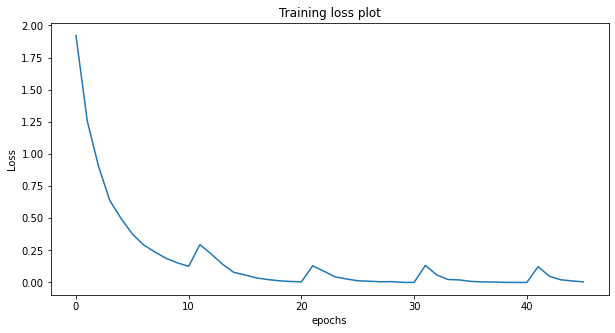

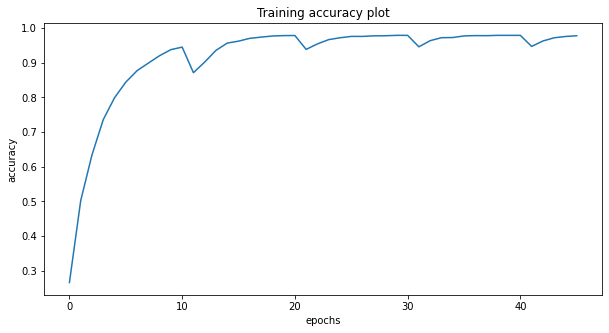

tensor(0.1232, device='cuda:0', dtype=torch.float64) 2.7039569857541252
Classes in order Actual and Predicted


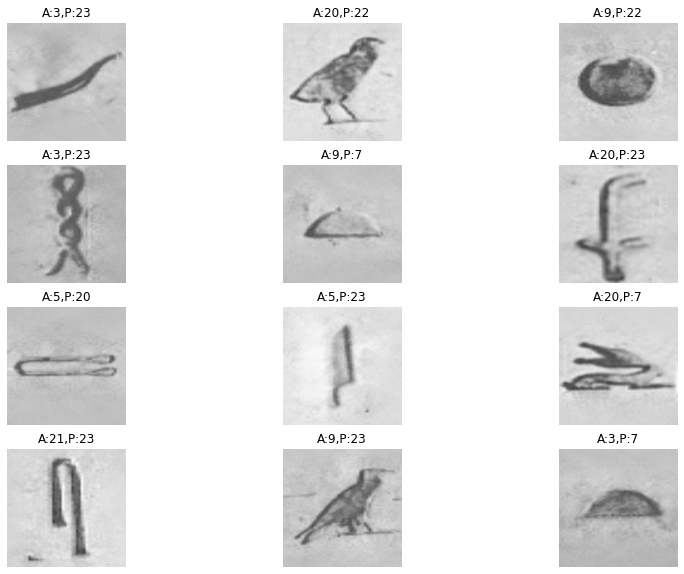

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 18.48406701625709 Recall: 12.492246126900586, Accuracy: 12.425860023724793: ,f1_score: 8.704458567345355
Confusion matrix, without normalization
[[ 49  29  33 102   4   0   0   0  85   4]
 [ 48  29  14 111   4   1   0   0  65   5]
 [ 81  40  63  79   4   1   0   0  85   7]
 [ 64  15   9 144   3   0   1   0  86   2]
 [ 43  57  19 112   2   5   0   0 131  12]
 [ 70  27   3 136   0   4   0   0  96   2]
 [ 99  21  25 111   2   3   3   0  57   1]
 [ 42  28  23 116   4   2   0   0 128  19]
 [ 70  30  22 122   5   0   0   0 120   2]
 [ 38  42  20  85   1   0   0   0 140   5]]


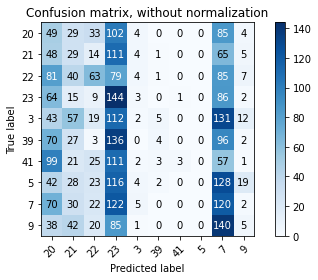

In [ ]:
train_model(classifier,dataloaders,criterion,50, patience = 45 , batch_size = batch_size , classes = classes)

In [ ]:
#Predict
from PIL import Image
import numpy as np
import cv2
def predict(model,image,device,encoder,transforms = None,inv_normalize = None):
    #model = torch.load('./model.h5')
    model.eval()
    if(isinstance(image,np.ndarray)):
      image = Image.fromarray(image)
    if(transforms!=None):
        image = transforms(image)
    data = image.expand(1,-1,-1,-1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim = 1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image,inv_normalize)
    prediction_bar(output,encoder)
    return preds
def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    a = a[0]
    
    size = len(a)
    if(size>5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
      prediction.append(float(output[:,i]*100))
      clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    plt.bar(clas,prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")
 
def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()

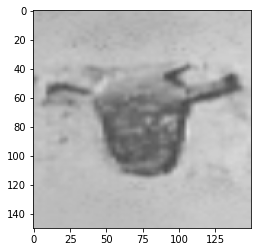

Class: 23 , confidence: 22.767059326171875
Class: 7 , confidence: 21.040735244750977
Class: 21 , confidence: 14.122027397155762
Class: 20 , confidence: 11.338603019714355
Class: 39 , confidence: 8.446647644042969


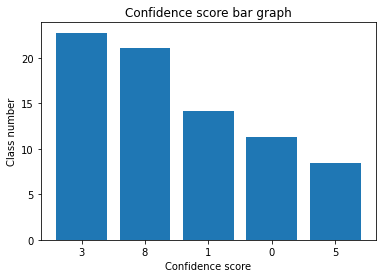

In [ ]:
image = cv2.imread('/content/drive/MyDrive/programs/Scriba/GlyphDataset/Dataset/Manual/Preprocessed/39/390003_F34.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)